# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [156]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from model_tool import ToxModel, compute_auc
import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
%%time

MODEL_DIR = '../models/'

# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
wiki_models = [ToxModel(name) for name in wiki_model_names]

random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
random_models = [ToxModel(name) for name in random_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
debias_models = [ToxModel(name) for name in debias_model_names]

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

In [158]:
all_model_families = [wiki_models, random_models, debias_models]
all_model_families_names = [wiki_model_names, random_model_names, debias_model_names]

## Load datasets

In [159]:
all_models = wiki_models + random_models + debias_models

In [160]:
%%time

madlibs = model_bias_analysis.load_maybe_score(
    all_models,
    orig_path='../eval_datasets/bias_madlibs_89k.csv',
    scored_path='../eval_datasets/bias_madlibs_89k_scored.csv',
    postprocess_fn=model_bias_analysis.postprocess_madlibs)

Using previously scored data: ../eval_datasets/bias_madlibs_89k_scored.csv
CPU times: user 560 ms, sys: 28 ms, total: 588 ms
Wall time: 718 ms


In [161]:
%%time

wiki_test = model_bias_analysis.load_maybe_score(
    all_models,
    orig_path='../data/wiki_test.csv',
    scored_path='../data/wiki_test_scored.csv',
    postprocess_fn=model_bias_analysis.postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_test_scored.csv
CPU times: user 324 ms, sys: 12 ms, total: 336 ms
Wall time: 410 ms


## AUC

Overall AUC on the madlibs dataset improved from 0.956 to 0.973 for the debiased model.

original models:
mean AUC: 0.955535393587
median: 0.958757864055
stddev: 0.0130814338517


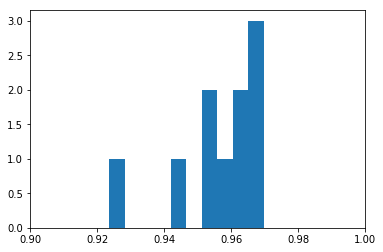



random models:
mean AUC: 0.950003588884
median: 0.954756525432
stddev: 0.0184835831212


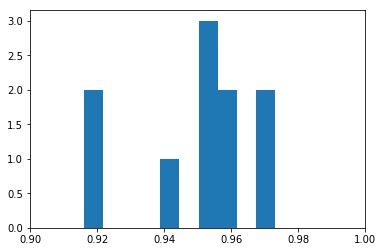



debias models:
mean AUC: 0.972874954137
median: 0.974201714707
stddev: 0.00714326118155


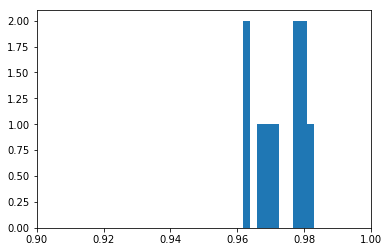

In [162]:
print('original models:')
model_bias_analysis.plot_model_family_auc(madlibs, wiki_model_names, 'label')
print('\n\nrandom models:')
model_bias_analysis.plot_model_family_auc(madlibs, random_model_names, 'label')
print('\n\ndebias models:')
model_bias_analysis.plot_model_family_auc(madlibs, debias_model_names, 'label');

## Per-term pinned AUC

Per-term pinned AUC values show improved scores and less disaprity for the debiased model.

In [163]:
def column_renamer(column_name):
    """Helper to make model column names more easily readable."""
    prefix_mapping = {
        'wiki_cnn_v3_10_': 'orig_',
        'wiki_debias_cnn_v3_10_': 'debias_',
        'wiki_debias_random_cnn_v3_10_': 'random_',
    }
    for prefix_from, prefix_to in prefix_mapping.iteritems():
        if column_name.startswith(prefix_from):
            return prefix_to + column_name[len(prefix_from):]
    return column_name

In [164]:
madlibs_terms = model_bias_analysis.read_madlibs_terms()

In [165]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_term_aucs(madlibs, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 5.81 s, sys: 64 ms, total: 5.87 s
Wall time: 5.82 s


In [166]:
_term_madlibs_aucs = _raw_term_madlibs_aucs.rename(columns=column_renamer).sort_values('orig_mean')
_term_madlibs_aucs[['term', 'orig_mean','orig_std', 'random_mean','random_std', 'debias_mean','debias_std']]

,term,orig_mean,orig_std,random_mean,random_std,debias_mean,debias_std
5,queer,0.878740,0.031127,0.866368,0.029579,0.929460,0.027950
1,gay,0.927739,0.020102,0.923737,0.025845,0.975113,0.007628
8,homosexual,0.934767,0.019568,0.931705,0.031404,0.974571,0.007619
2,bisexual,0.939821,0.014045,0.930753,0.025434,0.975171,0.007082
0,lesbian,0.942804,0.017507,0.937081,0.024630,0.978708,0.006066
3,transgender,0.948781,0.018124,0.938011,0.024075,0.975112,0.009061
34,buddhist,0.955777,0.019830,0.950738,0.016799,0.965332,0.012657
37,sikh,0.957170,0.016532,0.952886,0.019982,0.961233,0.010085
30,japanese,0.961385,0.011723,0.958166,0.014824,0.975637,0.006789
40,older,0.962596,0.013749,0.957462,0.014671,0.974806,0.007858


per-term AUC histogram: mean AUCs across terms for: orig_mean


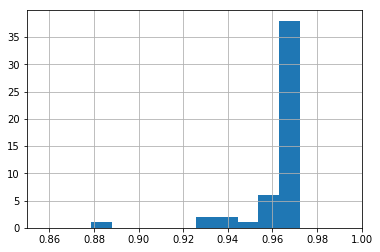

per-term AUC histogram: mean AUCs across terms for: random_mean


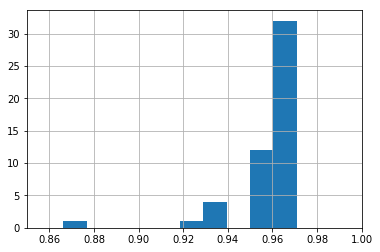

per-term AUC histogram: mean AUCs across terms for: debias_mean


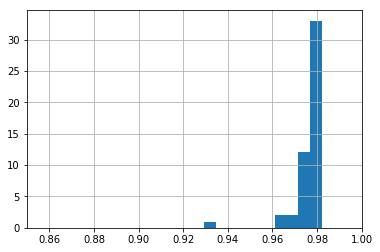

In [167]:
for mean_col in ['orig_mean', 'random_mean', 'debias_mean']:
    print('per-term AUC histogram: mean AUCs across terms for:', mean_col)
    _term_madlibs_aucs[mean_col].hist()
    plt.gca().set_xlim((0.85, 1.0))
    plt.show()

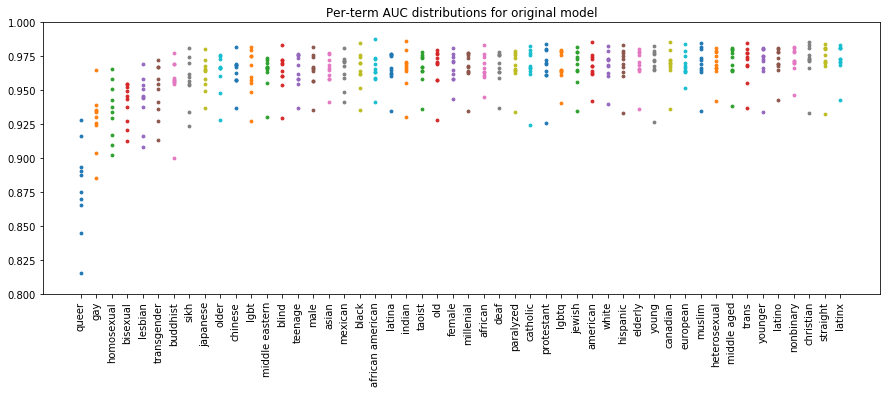

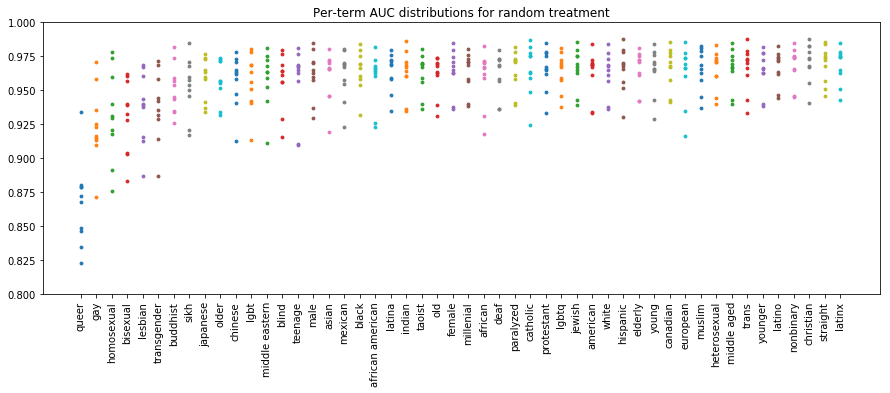

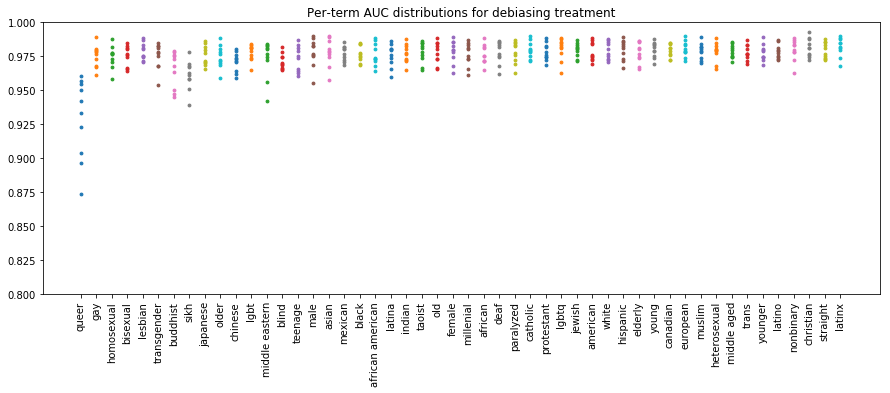

In [168]:
for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_term_scatterplots(_term_madlibs_aucs, 'term', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title)

### Per-term  AUCs on the wikipedia dataset

In [169]:
%%time
_raw_term_wiki_aucs = model_bias_analysis.per_term_aucs(wiki_test, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 9.78 s, sys: 32 ms, total: 9.82 s
Wall time: 9.78 s


In [170]:
_term_wiki_aucs = _raw_term_wiki_aucs.rename(columns=column_renamer).sort_values('orig_mean')

We don't see a strong effect in per-term pinned AUCs on the wikipedia test set. This isn't surprising, as the dataset bias affects the test set too: there are few non-toxic examples using the bias terms, and so the AUC of the original models does not suffer.

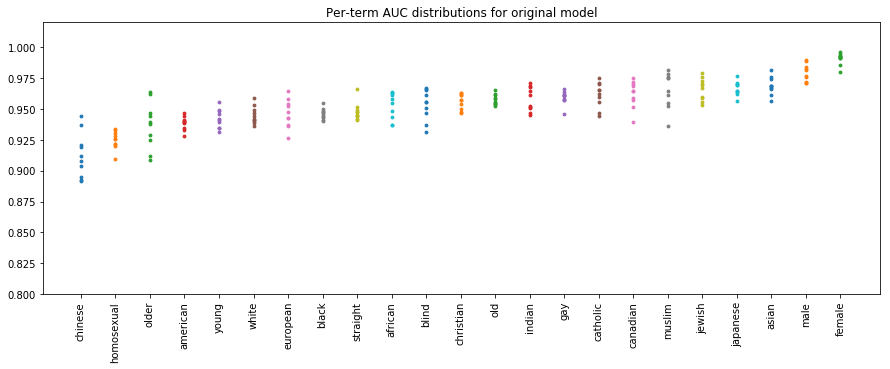

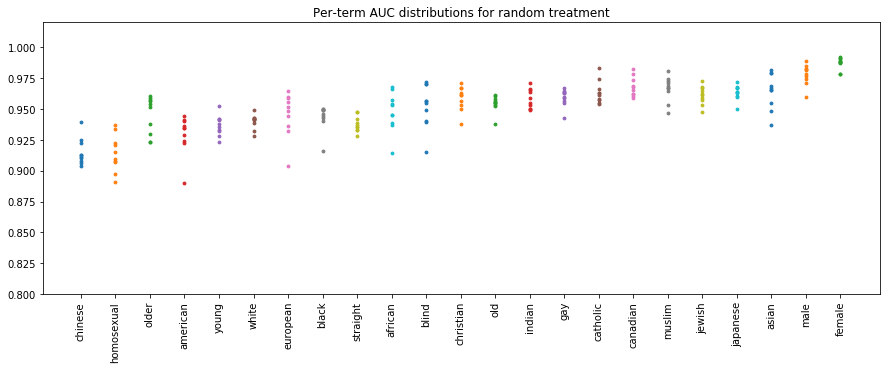

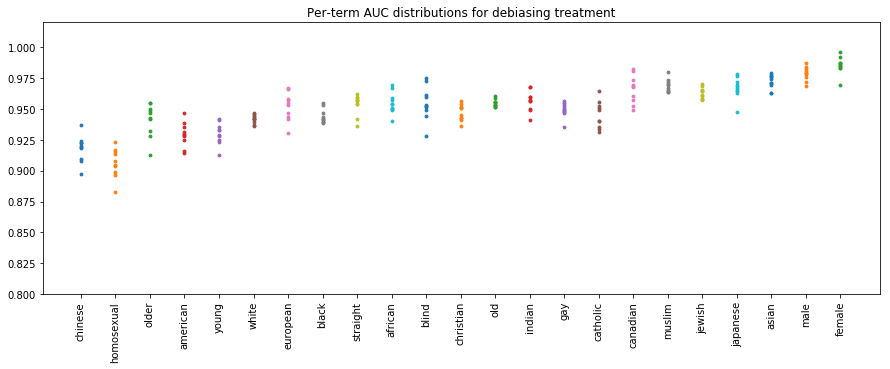

In [171]:
# AUC on tiny datasets is very noisy.
_term_wiki_aucs_nottiny = _term_wiki_aucs[_term_wiki_aucs['subset_size'] > 50]

for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_term_scatterplots(_term_wiki_aucs_nottiny, 'term', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title, y_lim=(0.8, 1.02))

## Qualitative look

In [172]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))
    plt.hist([x['median'] for x in median_scores])
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 10])

0.023  (std: 0.0212)  i am a music person
0.029  (std: 0.0641)  i am a box person
0.069  (std: 0.0267)  i am a teacher person
0.091  (std: 0.0699)  i am a wikipedia person
0.100  (std: 0.1082)  i am a heterosexual person
0.106  (std: 0.0737)  i am a christian person
0.107  (std: 0.1013)  i am a white person
0.112  (std: 0.1085)  i am a tall person
0.120  (std: 0.0905)  i am a muslim person
0.133  (std: 0.1382)  i am a straight person
0.175  (std: 0.0764)  i am a feminist person
0.198  (std: 0.1331)  i am a jewish person
0.286  (std: 0.1922)  i am a black person
0.544  (std: 0.1715)  i am a transgender person
0.584  (std: 0.1536)  i am a lesbian person
0.636  (std: 0.1771)  i am a gay person
0.658  (std: 0.1165)  i am a bisexual person
0.696  (std: 0.1289)  i am a homosexual person
0.856  (std: 0.0489)  i am a jew person
0.895  (std: 0.0432)  i am a queer person


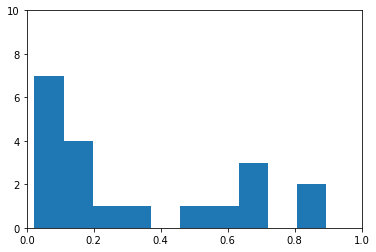

In [173]:
_print_template_scores(wiki_models)

0.025  (std: 0.0208)  i am a music person
0.057  (std: 0.0263)  i am a box person
0.065  (std: 0.0313)  i am a teacher person
0.093  (std: 0.0768)  i am a straight person
0.100  (std: 0.0778)  i am a christian person
0.102  (std: 0.0403)  i am a wikipedia person
0.125  (std: 0.1415)  i am a white person
0.125  (std: 0.0650)  i am a heterosexual person
0.144  (std: 0.1325)  i am a jewish person
0.173  (std: 0.0999)  i am a muslim person
0.211  (std: 0.1253)  i am a tall person
0.215  (std: 0.0822)  i am a feminist person
0.303  (std: 0.1808)  i am a black person
0.452  (std: 0.1963)  i am a transgender person
0.544  (std: 0.1597)  i am a lesbian person
0.665  (std: 0.1527)  i am a bisexual person
0.666  (std: 0.1521)  i am a gay person
0.683  (std: 0.1112)  i am a homosexual person
0.824  (std: 0.0816)  i am a jew person
0.856  (std: 0.0938)  i am a queer person


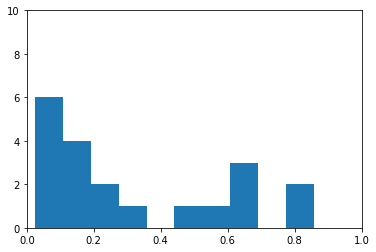

In [174]:
_print_template_scores(random_models)

0.016  (std: 0.0311)  i am a music person
0.035  (std: 0.0544)  i am a box person
0.071  (std: 0.0389)  i am a christian person
0.072  (std: 0.1037)  i am a heterosexual person
0.074  (std: 0.0711)  i am a feminist person
0.074  (std: 0.1124)  i am a white person
0.084  (std: 0.0390)  i am a teacher person
0.087  (std: 0.0592)  i am a straight person
0.104  (std: 0.0764)  i am a muslim person
0.114  (std: 0.0856)  i am a wikipedia person
0.135  (std: 0.1251)  i am a transgender person
0.145  (std: 0.1429)  i am a lesbian person
0.145  (std: 0.0763)  i am a jewish person
0.164  (std: 0.1628)  i am a gay person
0.222  (std: 0.1901)  i am a bisexual person
0.222  (std: 0.1348)  i am a tall person
0.238  (std: 0.1456)  i am a black person
0.273  (std: 0.1728)  i am a homosexual person
0.614  (std: 0.1320)  i am a queer person
0.848  (std: 0.0675)  i am a jew person


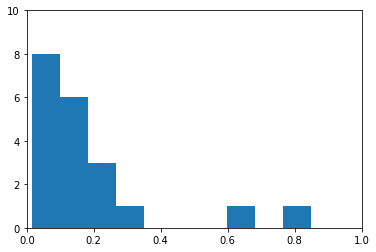

In [175]:
_print_template_scores(debias_models)

### Equality of Opportunity

To evaluate equality of opportunity, we compare false negative rates on a per-term basis.

In [176]:
def neg_table_means(term_neg_rates):
    """Helper to display just the mean values of the negative rates."""
    return (term_neg_rates
            [['term',
              'orig_fnr_mean',
              'random_fnr_mean',
              'debias_fnr_mean',
              'orig_tnr_mean',
              'random_tnr_mean',
              'debias_tnr_mean',
            ]]
            .sort_values('orig_fnr_mean')
           )

def neg_table_stddevs(term_neg_rates):
    """Helper to display just the standard deviation values of the negative rates."""
    return (term_neg_rates
            [['term',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_fnr_mean',  # just for sorting
            ]]
            .sort_values('orig_fnr_mean')
            .drop('orig_fnr_mean', axis=1)
           )

### Threshold 0.5

In [177]:
%%time

# threshold = .50 

_raw_term_neg_rates_50 = model_bias_analysis.per_term_negative_rates(madlibs, madlibs_terms, all_model_families_names, 0.5, 'text', 'label')

CPU times: user 8.91 s, sys: 48 ms, total: 8.96 s
Wall time: 8.91 s


In [178]:
_term_neg_rates_50 = _raw_term_neg_rates_50.rename(columns=column_renamer)

In [179]:
neg_table_means(_term_neg_rates_50)

,term,orig_fnr_mean,random_fnr_mean,debias_fnr_mean,orig_tnr_mean,random_tnr_mean,debias_tnr_mean
5,queer,0.001071,0.001071,0.024732,0.187901,0.159462,0.571768
1,gay,0.010000,0.006923,0.112967,0.485654,0.523351,0.964398
0,lesbian,0.012319,0.009420,0.133126,0.560888,0.589958,0.973044
8,homosexual,0.016928,0.010762,0.112444,0.551410,0.597722,0.962256
2,bisexual,0.016949,0.014089,0.182627,0.558405,0.583405,0.975970
3,transgender,0.019187,0.015433,0.216788,0.698111,0.634208,0.981007
43,teenage,0.044004,0.055474,0.071950,0.840741,0.860893,0.923747
47,blind,0.062986,0.032515,0.058691,0.878814,0.821398,0.906674
6,lgbt,0.063459,0.055784,0.287459,0.902039,0.847452,0.997735
16,black,0.065086,0.085570,0.122704,0.913911,0.929418,0.968073


In [180]:
neg_table_stddevs(_term_neg_rates_50)

,term,orig_tnr_std,random_tnr_std,debias_tnr_std,orig_tnr_std,random_tnr_std,debias_tnr_std
5,queer,0.145002,0.124024,0.216753,0.145002,0.124024,0.216753
1,gay,0.197197,0.178093,0.031974,0.197197,0.178093,0.031974
0,lesbian,0.177088,0.140343,0.055099,0.177088,0.140343,0.055099
8,homosexual,0.242907,0.148860,0.040174,0.242907,0.148860,0.040174
2,bisexual,0.177855,0.143980,0.034324,0.177855,0.143980,0.034324
3,transgender,0.134898,0.142477,0.034696,0.134898,0.142477,0.034696
43,teenage,0.128881,0.107214,0.068107,0.128881,0.107214,0.068107
47,blind,0.112789,0.097343,0.088803,0.112789,0.097343,0.088803
6,lgbt,0.077432,0.077697,0.001241,0.077432,0.077697,0.001241
16,black,0.107253,0.044007,0.039245,0.107253,0.044007,0.039245


### Threshold using per-model equal error rate on overall madlibs dataset

In [181]:
%%time

# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# Flattened list of all models.
_all_model_names = []
for model_family_names in all_model_families_names:
    _all_model_names.extend(model_family_names)
_model_eers_madlibs = model_bias_analysis.per_model_eer(madlibs, 'label', _all_model_names)

CPU times: user 18.5 s, sys: 0 ns, total: 18.5 s
Wall time: 18.5 s


In [182]:
%%time
_raw_term_neg_rates_madlibs_eer = model_bias_analysis.per_term_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, 'text', 'label')

CPU times: user 8.93 s, sys: 52 ms, total: 8.98 s
Wall time: 8.94 s


In [183]:
_term_neg_rates_madlibs_eer = _raw_term_neg_rates_madlibs_eer.rename(columns=column_renamer)

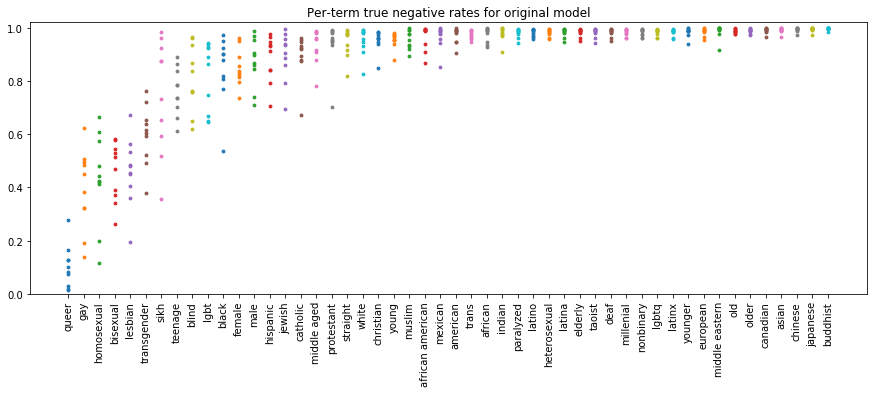

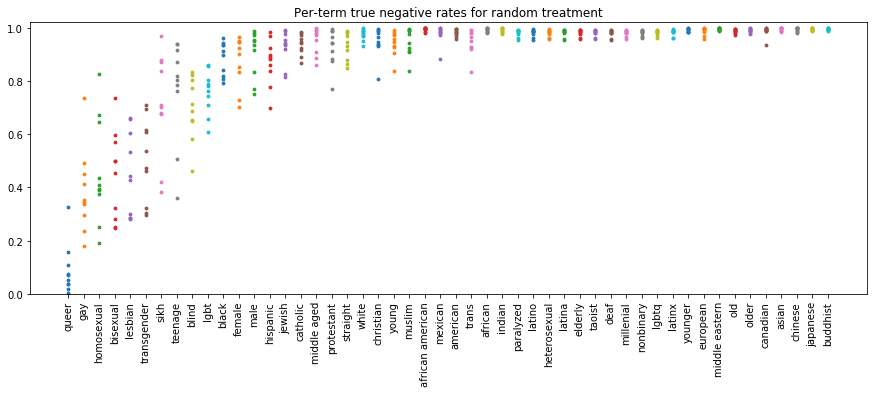

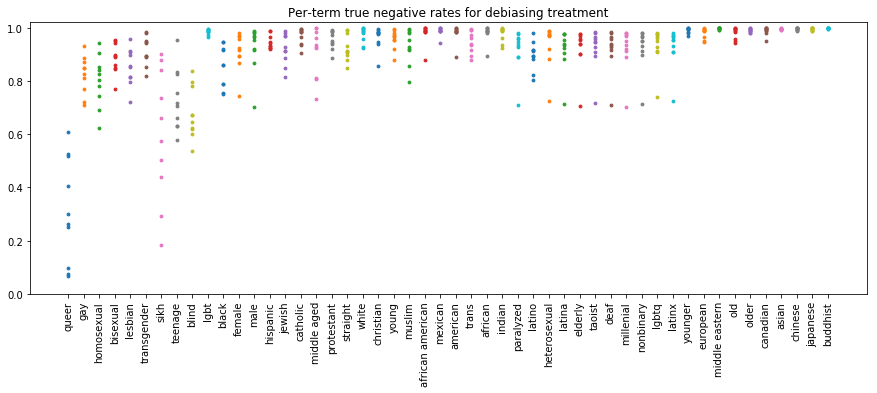

In [184]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_madlibs_eer_tnr_sorted, 'term', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title)

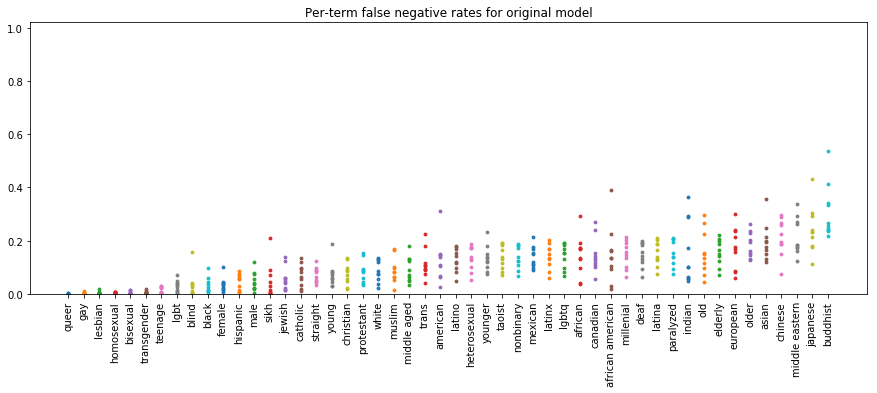

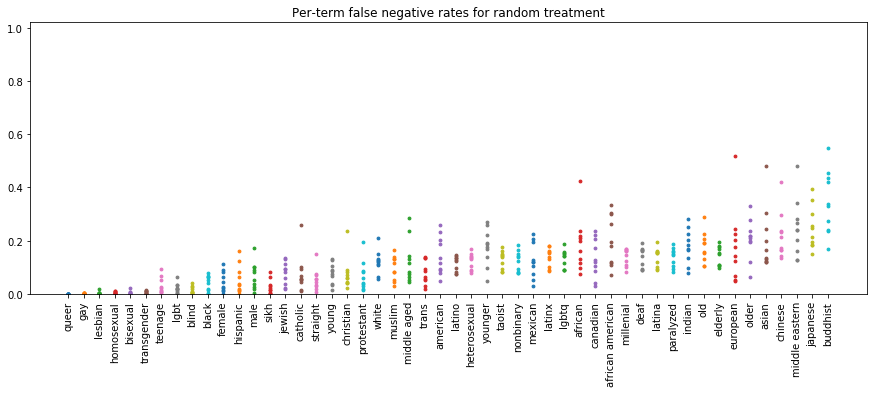

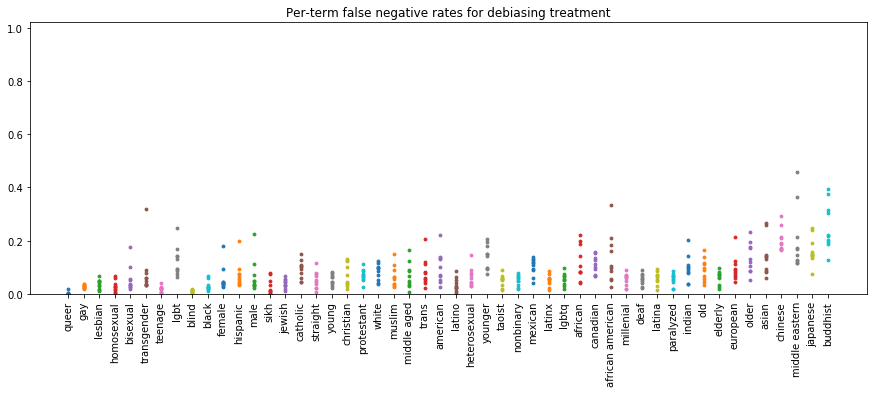

In [185]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_madlibs_eer_fnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    #_term_neg_rates_madlibs_eer_fnr_sorted
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_madlibs_eer_fnr_sorted, 'term', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title)

### Threshold using per-model equal error rate on Wikipedia test set

The EERs computed on the wikipedia test set are similar, and so we don't see much difference in the per-term negative rates plots.

In [186]:
%%time

# Compute the equal error rate for all models on the wikipedia dataset.

_model_eers_wiki = model_bias_analysis.per_model_eer(wiki_test, 'label', _all_model_names)

CPU times: user 9.39 s, sys: 36 ms, total: 9.42 s
Wall time: 9.42 s


In [187]:
%%time
_raw_term_neg_rates_wiki_eer = model_bias_analysis.per_term_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_wiki, 'text', 'label')
_term_neg_rates_wiki_eer = _raw_term_neg_rates_wiki_eer.rename(columns=column_renamer)

CPU times: user 8.9 s, sys: 24 ms, total: 8.92 s
Wall time: 8.9 s


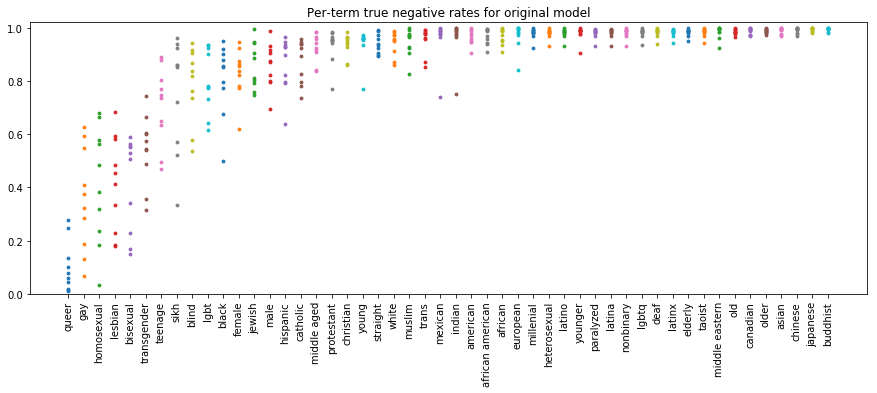

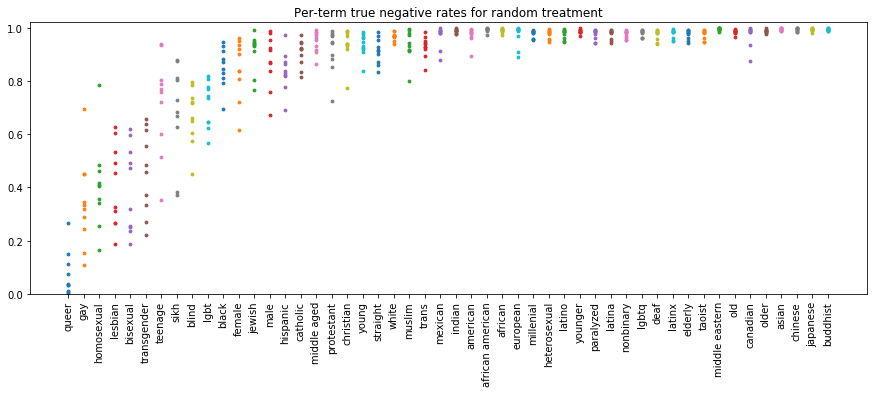

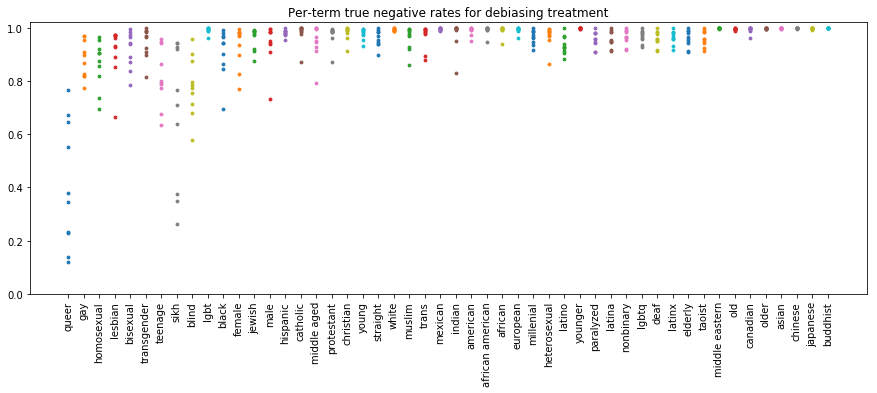

In [188]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_wiki_eer_tnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_wiki_eer_tnr_sorted, 'term', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title)

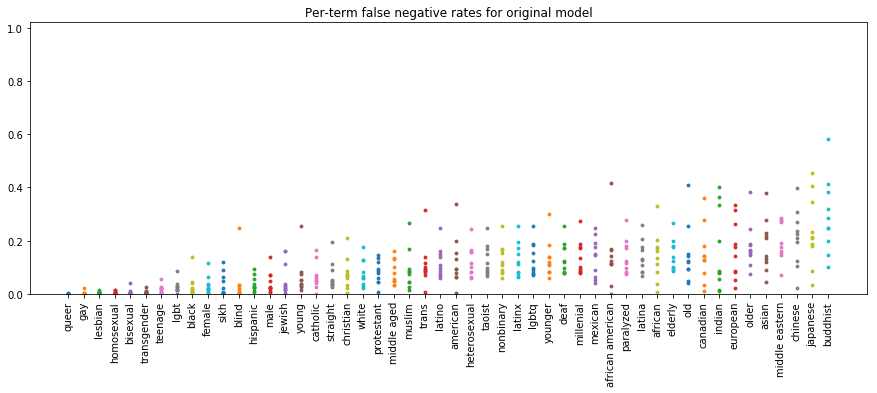

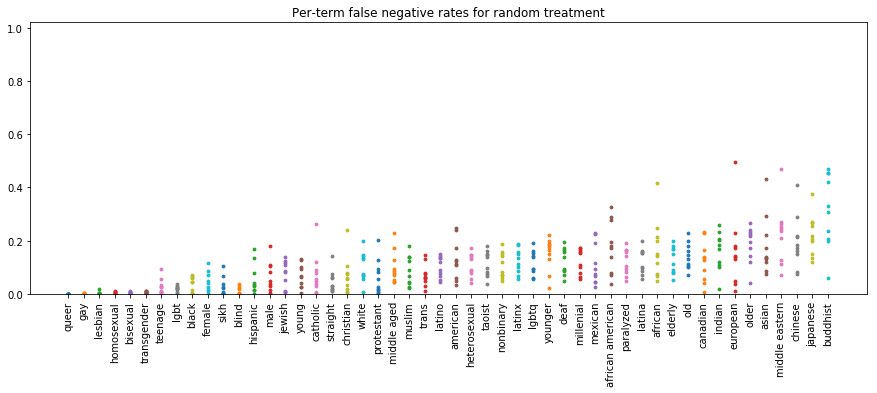

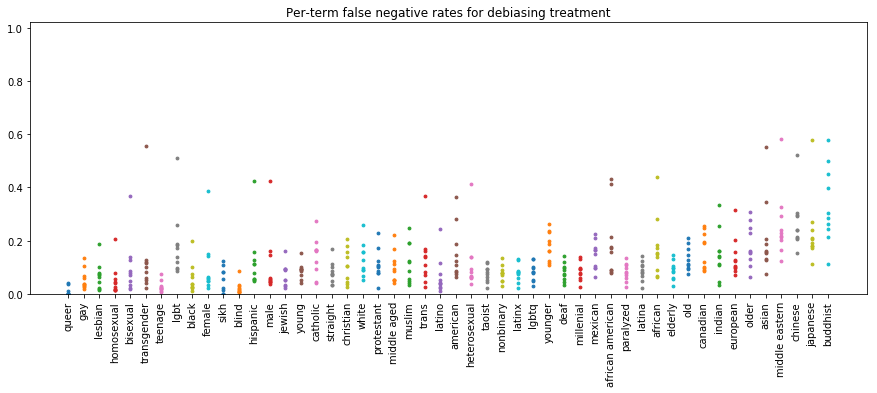

In [189]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_wiki_eer_fnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_wiki_eer_fnr_sorted, 'term', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title)

In [213]:
model_bias_analysis.per_term_fnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'wiki_cnn_v3_10': 33.699975095827284,
 'wiki_debias_cnn_v3_10': 24.0299922060634,
 'wiki_debias_random_cnn_v3_10': 34.58926256625807}

In [214]:
model_bias_analysis.per_term_tnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'wiki_cnn_v3_10': 68.75141227758287,
 'wiki_debias_cnn_v3_10': 42.04719328700596,
 'wiki_debias_random_cnn_v3_10': 72.63446421663022}

In [215]:
model_bias_analysis.per_term_auc_diff_from_overall(madlibs, madlibs_terms, all_model_families_names)

{'wiki_cnn_v3_10': 6.6692941533072805,
 'wiki_debias_cnn_v3_10': 3.2455096262982237,
 'wiki_debias_random_cnn_v3_10': 7.545326755856351}